# Reading and Writing Data with Spark

This notebook contains the code from the previous screencast. The only difference is that instead of reading in a dataset from a remote cluster, the data set is read in from a local file. You can see the file by clicking on the "jupyter" icon and opening the folder titled "data".

Run the code cell to see how everything works. 

First let's import SparkConf and SparkSession

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import desc, asc
from pyspark.sql.functions import sum as Fsum

from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark

import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


Since we're using Spark locally we already have both a sparkcontext and a sparksession running. We can update some of the parameters, such our application's name. Let's just call it "Our first Python Spark SQL example"

In [5]:
spark = SparkSession \
    .builder \
    .appName("Our first Python Spark SQL example") \
    .getOrCreate()

Let's check if the change went through

In [6]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'Our first Python Spark SQL example'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '192.168.0.8'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.sql.warehouse.dir',
  'file:/home/zen/Documentos/Python%20Projects/Udacity_DataEngineer/3_data_lakes/lesson_2/spark-warehouse'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.app.startTime', '1630868509765'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '33049'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1630868510948')]

In [7]:
spark

As you can see the app name is exactly how we set it

Let's create our first dataframe from a fairly small sample data set. Througout the course we'll work with a log file data set that describes user interactions with a music streaming service. The records describe events such as logging in to the site, visiting a page, listening to the next song, seeing an ad.

In [8]:
path = "./data/sparkify_log_small.json"
user_log = spark.read.json(path)

In [9]:
user_log.take(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [10]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [11]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [12]:
user_log.describe('artist').show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [13]:
user_log.describe('sessionId').show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [14]:
user_log.describe('ts').show()

+-------+-------------------+
|summary|                 ts|
+-------+-------------------+
|  count|              10000|
|   mean| 1.5137859954164E12|
| stddev|3.290828862357974E7|
|    min|      1513720872284|
|    max|      1513848349284|
+-------+-------------------+



In [15]:
# number o rows
user_log.count()

10000

In [17]:
user_log.select('page').dropDuplicates().sort('page').show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [18]:
user_log.select(['userId', 'firstname', 'page', 'song']).where(user_log.userId == '1046').collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

In [22]:
# create an user defined column
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [23]:
# add a new column
user_log = user_log.withColumn('hour', get_hour(user_log.ts))

# Because the lazy evaluation, nothing was computed so far. Spark will only compute hour in the next line, when we call the head of dataset.

In [24]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='20')

In [25]:
song_hour = user_log.filter(user_log.page == 'NextSong').groupby(user_log.hour).count().orderBy(user_log.hour.cast('float'))

In [26]:
song_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  382|
|   1|  302|
|   2|  352|
|   3|  276|
|   4|  348|
|   5|  358|
|   6|  375|
|   7|  249|
|   8|  216|
|   9|  228|
|  10|  251|
|  11|  339|
|  12|  462|
|  13|  479|
|  14|  484|
|  15|  430|
|  16|  362|
|  17|  295|
|  18|  257|
|  19|  248|
+----+-----+
only showing top 20 rows



In [29]:
song_in_hour_pd = song_hour.toPandas()

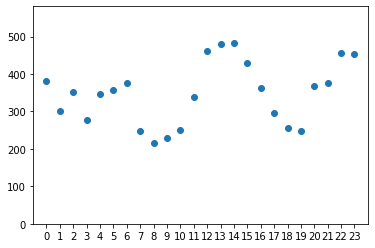

In [31]:
plt.scatter(song_in_hour_pd['hour'], song_in_hour_pd['count'])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(song_in_hour_pd['count']));

In [33]:
# Checking missing values
user_log_valid = user_log.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [34]:
user_log_valid.count()

10000

In [37]:
user_log.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [38]:
user_log_valid = user_log_valid.filter(user_log_valid['userId'] != '')

In [39]:
user_log_valid.count()

9664

In [40]:
# Check users that made a downgrade
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|   9|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [41]:
user_log.select(['userId', 'firstname', 'page', 'level', 'song']).where(user_log.userId == '1138').collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [42]:
flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())

In [43]:
user_log_valid = user_log_valid.withColumn('downgraded', flag_downgrade_event('page'))

In [44]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='20', downgraded=0)

In [45]:
from pyspark.sql import Window

In [46]:
windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)

In [49]:
user_log_valid = user_log_valid.withColumn('phase', Fsum('downgraded').over(windowval))

In [51]:
user_log_valid.select(['userId', 'firstname', 'ts', 'page', 'level', 'phase']).where(user_log.userId == '1138').sort('ts').collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs

# Quiz

In [59]:
#Q1
user_log.select('page').where(user_log.userId == '').dropDuplicates().show()

+-----+
| page|
+-----+
| Home|
|About|
|Login|
| Help|
+-----+



In [61]:
# Q2
user_log.filter(user_log.userId == '').show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+----+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|hour|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+----+
|  null|Logged Out|     null|  null|            0|    null|  null| free|    null|   PUT|Login|        null|     5598|null|   307|1513721196284|     null|      |  20|
|  null|Logged Out|     null|  null|           26|    null|  null| paid|    null|   GET| Home|        null|      428|null|   200|1513721274284|     null|      |  20|
|  null|Logged Out|     null|  null|            5|    null|  null| free|    null|   GET| Home|        null|     2941|null|   200|1513722009284|     null|      |  20|
|  n

In [74]:
# Q1.1
user_log.filter(user_log.userId == '').groupBy('level').count().orderBy('count').show()

+-----+-----+
|level|count|
+-----+-----+
| paid|  143|
| free|  193|
+-----+-----+



In [73]:
# Q1.2
user_log.filter(user_log.userId == '').groupBy('page').count().orderBy('count').show()

+-----+-----+
| page|count|
+-----+-----+
| Help|    8|
|About|   15|
|Login|  126|
| Home|  187|
+-----+-----+



In [80]:
# Q3.
user_log.dropDuplicates(['userId']).filter(user_log.gender == 'F').count()

462

In [89]:
#Q4
user_log.groupBy('artist').count().sort(desc('count')).show(truncate=False)

+----------------------------------------------------------------------+-----+
|artist                                                                |count|
+----------------------------------------------------------------------+-----+
|null                                                                  |1653 |
|Coldplay                                                              |83   |
|Kings Of Leon                                                         |69   |
|Florence + The Machine                                                |52   |
|BjÃÂ¶rk                                                              |46   |
|Dwight Yoakam                                                         |45   |
|Justin Bieber                                                         |43   |
|The Black Keys                                                        |40   |
|OneRepublic                                                           |37   |
|Jack Johnson                                       